In [679]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

from raif_hack.data_transformers import SmoothedTargetEncoding

from raif_hack.model import BenchmarkModel
from raif_hack.settings import MODEL_PARAMS, LOGGING_CONFIG, NUM_FEATURES, CATEGORICAL_OHE_FEATURES,CATEGORICAL_STE_FEATURES,TARGET
from raif_hack.utils import PriceTypeEnum
from raif_hack.metrics import metrics_stat, deviation_metric
from raif_hack.features import prepare_categorical

In [680]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

/home/artem/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [681]:
train_df.floor.isna().sum()

176237

In [682]:
CATEGORICAL_STE_FEATURES = ['region', 'city', 'realty_type', 'floor']

# признаки, для которых применяем one hot encoding
CATEGORICAL_OHE_FEATURES = []

# численные признаки
NUM_FEATURES = ['lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
      'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
       'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
       'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
       'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
       'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
       'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
       'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
       'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
       'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
       'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
       'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
       'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.005',
       'osm_train_stop_points_in_0.0075', 'osm_train_stop_points_in_0.01',
       'osm_transport_stop_closest_dist', 'osm_transport_stop_points_in_0.005',
       'osm_transport_stop_points_in_0.0075',
       'osm_transport_stop_points_in_0.01',
       'reform_count_of_houses_1000', 'reform_count_of_houses_500',
       'reform_house_population_1000', 'reform_house_population_500',]

In [683]:
def prepare_categorical(df):
    """
    Заполняет пропущенные категориальные переменные
    :param df: dataframe, обучающая выборка
    :return: dataframe
    """
    df_new = df.copy()
    fillna_cols = ['region','city','street','realty_type','floor']
    df_new[fillna_cols] = df_new[fillna_cols].fillna('Missing')
    return df_new

In [684]:
train_df = prepare_categorical(train_df)
test_df = prepare_categorical(test_df)

In [655]:
train_df.floor = train_df.floor.astype(str)
train_df.floor = train_df.floor.str.lower()
train_df.floor.unique()

array(['missing', '3.0', '4.0', '-1.0', '1.0', '14.0', '2.0', '8.0',
       '-2.0', '6.0', '10.0', '5.0', '16.0', '19.0', '7.0', '9.0', '58.0',
       '24.0', '18.0', '26.0', '17.0', '48.0', '11.0', '-3.0', '15.0',
       '22.0', '60.0', '12.0', '21.0', '35.0', '28.0', '38.0', '39.0',
       '13.0', '81.0', '44.0', '82.0', '25.0', '45.0', '47.0', '23.0',
       '37.0', '29.0', '113.0', '78.0', '42.0', '69.0', '27.0', '46.0',
       '53.0', '80.0', '70.0', '76.0', '64.0', '30.0', '73.0', '77.0',
       '52.0', '67.0', '65.0', '20.0', '40.0', '49.0', '75.0', '93.0',
       '94.0', '91.0', '72.0', '79.0', '84.0', '92.0', '33.0', '66.0',
       '90.0', '31.0', '36.0', '61.0', '71.0', '68.0', '51.0', '97.0',
       '43.0', '95.0', '85.0', '50.0', '0.0', '62.0', '54.0', '74.0',
       '57.0', '41.0', '34.0', '59.0', '56.0', '123.0', '55.0', '83.0',
       '1', 'подвал, 1', '2', 'подвал', 'цоколь, 1', '1,2,антресоль',
       'цоколь', '4', '5', 'тех.этаж (6)', '3', '10',
       'фактически на

In [660]:
train_df[train_df.floor.str.contains('подвал')]='подвал'
train_df[train_df.floor.str.contains('мансарда')]='мансарда'

In [661]:
train_df.floor.unique()

array(['missing', '3.0', '4.0', '-1.0', '1.0', '14.0', '2.0', '8.0',
       '-2.0', '6.0', '10.0', '5.0', '16.0', '19.0', '7.0', '9.0', '58.0',
       '24.0', '18.0', '26.0', '17.0', '48.0', '11.0', '-3.0', '15.0',
       '22.0', '60.0', '12.0', '21.0', '35.0', '28.0', '38.0', '39.0',
       '13.0', '81.0', '44.0', '82.0', '25.0', '45.0', '47.0', '23.0',
       '37.0', '29.0', '113.0', '78.0', '42.0', '69.0', '27.0', '46.0',
       '53.0', '80.0', '70.0', '76.0', '64.0', '30.0', '73.0', '77.0',
       '52.0', '67.0', '65.0', '20.0', '40.0', '49.0', '75.0', '93.0',
       '94.0', '91.0', '72.0', '79.0', '84.0', '92.0', '33.0', '66.0',
       '90.0', '31.0', '36.0', '61.0', '71.0', '68.0', '51.0', '97.0',
       '43.0', '95.0', '85.0', '50.0', '0.0', '62.0', '54.0', '74.0',
       '57.0', '41.0', '34.0', '59.0', '56.0', '123.0', '55.0', '83.0',
       '1', 'подвал', '2', 'цоколь, 1', '1,2,антресоль', 'цоколь', '4',
       '5', 'тех.этаж (6)', '3', '10', 'фактически на уровне 1 этажа',
  

In [615]:
train_df.floor = train_df.floor.astype(str)
test_df.floor = test_df.floor.astype(str)

In [616]:
train_df.floor.unique()

array(['Missing', '3.0', '4.0', '-1.0', '1.0', '14.0', '2.0', '8.0',
       '-2.0', '6.0', '10.0', '5.0', '16.0', '19.0', '7.0', '9.0', '58.0',
       '24.0', '18.0', '26.0', '17.0', '48.0', '11.0', '-3.0', '15.0',
       '22.0', '60.0', '12.0', '21.0', '35.0', '28.0', '38.0', '39.0',
       '13.0', '81.0', '44.0', '82.0', '25.0', '45.0', '47.0', '23.0',
       '37.0', '29.0', '113.0', '78.0', '42.0', '69.0', '27.0', '46.0',
       '53.0', '80.0', '70.0', '76.0', '64.0', '30.0', '73.0', '77.0',
       '52.0', '67.0', '65.0', '20.0', '40.0', '49.0', '75.0', '93.0',
       '94.0', '91.0', '72.0', '79.0', '84.0', '92.0', '33.0', '66.0',
       '90.0', '31.0', '36.0', '61.0', '71.0', '68.0', '51.0', '97.0',
       '43.0', '95.0', '85.0', '50.0', '0.0', '62.0', '54.0', '74.0',
       '57.0', '41.0', '34.0', '59.0', '56.0', '123.0', '55.0', '83.0',
       '1', 'подвал, 1', '2', 'подвал', 'цоколь, 1', '1,2,антресоль',
       'цоколь', '4', '5', 'тех.этаж (6)', '3', 'Подвал', 'Цоколь', '10',
 

In [617]:
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=mutual_info_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [618]:
# plt.figure(figsize=(70,70))
# cor = train_df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [619]:
# cor_target = abs(cor["per_square_meter_price"])
# relevant_features = cor_target[cor_target>0.1]
# relevant_features.index

In [685]:
def deviation_metric_one_sample(y_true, y_pred):
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9

In [686]:
def deviation_metric(y_true, y_pred):
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

In [687]:
# feature = ['lat', 'lng', 'osm_amenity_points_in_0.001',
#        'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
#        'osm_amenity_points_in_0.01', 'osm_catering_points_in_0.001',
#        'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
#        'osm_catering_points_in_0.01', 'osm_city_closest_dist',
#        'osm_city_nearest_population', 'osm_crossing_points_in_0.001',
#        'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
#        'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
#        'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
#        'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
#        'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
#        'osm_finance_points_in_0.01', 'osm_healthcare_points_in_0.005',
#        'osm_healthcare_points_in_0.0075', 'osm_healthcare_points_in_0.01',
#        'osm_historic_points_in_0.005', 'osm_historic_points_in_0.0075',
#        'osm_historic_points_in_0.01', 'osm_hotels_points_in_0.005',
#        'osm_hotels_points_in_0.0075', 'osm_hotels_points_in_0.01',
#        'osm_leisure_points_in_0.005', 'osm_leisure_points_in_0.0075',
#        'osm_leisure_points_in_0.01', 'osm_offices_points_in_0.001',
#        'osm_offices_points_in_0.005', 'osm_offices_points_in_0.0075',
#        'osm_offices_points_in_0.01', 'osm_shops_points_in_0.001',
#        'osm_shops_points_in_0.005', 'osm_shops_points_in_0.0075',
#        'osm_shops_points_in_0.01', 'osm_subway_closest_dist',
#        'osm_train_stop_closest_dist', 'osm_train_stop_points_in_0.0075',
#        'osm_train_stop_points_in_0.01', 'osm_transport_stop_points_in_0.005',
#        'osm_transport_stop_points_in_0.0075',
#        'osm_transport_stop_points_in_0.01',
#        'reform_count_of_houses_1000', 'reform_house_population_1000',
#        'reform_house_population_500', 'reform_mean_floor_count_1000',
#        'reform_mean_floor_count_500', 'realty_type']

In [688]:
# NUM_FEATURES = [x for x in NUM_FEATURES if x in feature]
# CATEGORICAL_OHE_FEATURES = [x for x in CATEGORICAL_OHE_FEATURES  if x in feature]
# CATEGORICAL_STE_FEATURES = [x for x in CATEGORICAL_STE_FEATURES if x in feature]

In [689]:
numerical_features=NUM_FEATURES
ohe_categorical_features=CATEGORICAL_OHE_FEATURES
ste_categorical_features=CATEGORICAL_STE_FEATURES 

In [690]:
CATEGORICAL_STE_FEATURES

['region', 'city', 'realty_type', 'floor']

In [700]:
X_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
y_offer = train_df[train_df.price_type == PriceTypeEnum.OFFER_PRICE][TARGET]
X_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]
y_manual = train_df[train_df.price_type == PriceTypeEnum.MANUAL_PRICE][TARGET]
X_sub = test_df[NUM_FEATURES+CATEGORICAL_OHE_FEATURES+CATEGORICAL_STE_FEATURES]

In [692]:
# preprocessor = ColumnTransformer(transformers=[
#             ('num', StandardScaler(), numerical_features),
#             ('ohe', OneHotEncoder(), ohe_categorical_features),
#             ('ste', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),
#              ste_categorical_features)])
# X_offer = preprocessor.fit_transform(X_offer)
# X_manual = preprocessor.fit_transform(X_manual)

In [693]:
# scaler =StandardScaler()

# X_sub[numerical_features]  = scaler.fit_transform(X_sub[numerical_features])
# X_offer[numerical_features]  = scaler.fit_transform(X_offer[numerical_features])
# X_manual[numerical_features] = scaler.fit_transform(X_manual[numerical_features])

In [694]:
# X_offer, test_df = select_features(X_offer, y_offer, test_df)

In [695]:
MODEL_PARAMS = dict(
            n_estimators=3000,
            learning_rate=0.1,
            
#             num_leaves=40,
#             min_child_samples=5,
            
         
            random_state=563,
        )

In [696]:

        
pipeline = CatBoostRegressor( **MODEL_PARAMS,
#                              task_type="GPU",
#                            devices='0:1'
                          eval_metric = 'RMSE'
)

In [705]:
X_offer.floor = pd.to_numeric(X_offer.floor , errors='coerce')
X_offer.floor.unique()

array([ nan,   3.,   4.,  -1.,   1.,  14.,   2.,   8.,  -2.,   6.,  10.,
         5.,  16.,  19.,   7.,   9.,  58.,  24.,  18.,  26.,  17.,  48.,
        11.,  -3.,  15.,  22.,  60.,  12.,  21.,  35.,  28.,  38.,  39.,
        13.,  81.,  44.,  82.,  25.,  45.,  47.,  23.,  37.,  29., 113.,
        78.,  42.,  69.,  27.,  46.,  53.,  80.,  70.,  76.,  64.,  30.,
        73.,  77.,  52.,  67.,  65.,  20.,  40.,  49.,  75.,  93.,  94.,
        91.,  72.,  79.,  84.,  92.,  33.,  66.,  90.,  31.,  36.,  61.,
        71.,  68.,  51.,  97.,  43.,  95.,  85.,  50.,   0.,  62.,  54.,
        74.,  57.,  41.,  34.,  59.,  56., 123.,  55.,  83.])

In [632]:
X_sub.floor.unique()

array(['1.0', '-1.0', 'Missing', '2,3', '2', '-2.0', '5.0', '4', '1', '5',
       '1, 2', '1,2,3', '2.0', '4.0', '1,2,3,4', 'цоколь', '3', 'подвал',
       '3.0', '11.0', '9.0', '12.0', '0.0', 'цоколь, 1, 2,3,4,5,6', '6',
       '1,2', ' 1, 2, Антресоль', '6.0', '3 этаж, мансарда (4 этаж)',
       'цокольный', '1-й, 2-й', '13', '1, подвал', '7', '1, 2, 3', '1,2 ',
       '14', '9', 'подвал,1', '1-й', '8', '3,4', 'мансарда',
       'подвал, 1 и 4 этаж', '10.0', '5(мансарда)',
       'технический этаж,5,6', ' 1-2, подвальный', '1, 2, 3, мансардный',
       '8.0', '7.0', 'подвал, 1, 2, 3',
       '1,2,3, антресоль, технический этаж', '3, 4', '4, 5',
       '1-3 этажи, цоколь (188,4 кв.м), подвал (104 кв.м)',
       '1,2,3,4, подвал', '2-й', '1, 2 этаж', '1,2,3,4,5', 'подвал, 1, 2',
       '1-7', '1 (по док-м цоколь)', '1-й, подвал', '10', '1,2,подвал ',
       '13.0', 'подвал, 2', '1, цоколь', 'подвал,1,2,3',
       '1,2,3 этаж, подвал', 'цоколь, 1', '2, 3, 4, тех.этаж',
       'цокольный

In [644]:
X_manual.floor.unique()

array(['Missing', '2.0', '1', '-1.0', '1.0', '3.0', '18.0', 'подвал, 1',
       '2', '4.0', 'подвал', 'цоколь, 1', '1,2,антресоль', '5.0', '6.0',
       'цоколь', '9.0', '4', '5', 'тех.этаж (6)', '3', 'Подвал', 'Цоколь',
       '10', 'фактически на уровне 1 этажа', '6', '1,2,3', '1, подвал',
       '1,2,3,4', '1,2', '1,2,3,4,5', '5, мансарда', '-2.0', '10.0',
       '1-й, подвал', '12', '15', '13', '1, подвал, антресоль', '16.0',
       'мезонин', 'подвал, 1-3', '8', '7', '15.0', '1 (Цокольный этаж)',
       '3, Мансарда (4 эт)', 'подвал,1', '1, антресоль', '1-3',
       'мансарда (4эт)', '1, 2.', '9', '7.0', 'подвал , 1 ', '1, 2',
       'подвал, 1,2,3', '0.0', '1 + подвал (без отделки)', 'мансарда',
       '2,3', '4, 5', '1-й, 2-й', '18', '1 этаж, подвал', '17.0',
       '1, цоколь', 'подвал, 1-7, техэтаж', '3 (антресоль)', '1, 2, 3',
       'Цоколь, 1,2(мансарда)', 'подвал, 3. 4 этаж', 'подвал, 1-4 этаж',
       'подва, 1.2 этаж', '2, 3', '-1', '1.2', '11', '36', '7,8',
       '1 эт

In [633]:
pipeline.fit(X_manual, y_manual, cat_features=ste_categorical_features)

0:	learn: 86580.6510786	total: 3.47ms	remaining: 10.4s
1:	learn: 84055.1273933	total: 6.95ms	remaining: 10.4s
2:	learn: 81875.6891388	total: 10.3ms	remaining: 10.3s
3:	learn: 79974.3628048	total: 13.7ms	remaining: 10.3s
4:	learn: 78467.1654665	total: 17.1ms	remaining: 10.2s
5:	learn: 76853.0274610	total: 20.4ms	remaining: 10.2s
6:	learn: 75415.8871664	total: 24.2ms	remaining: 10.3s
7:	learn: 74223.8888892	total: 27.5ms	remaining: 10.3s
8:	learn: 73050.7869450	total: 30.9ms	remaining: 10.3s
9:	learn: 72162.7048184	total: 34.1ms	remaining: 10.2s
10:	learn: 71254.0560404	total: 38ms	remaining: 10.3s
11:	learn: 70443.2229894	total: 41.2ms	remaining: 10.3s
12:	learn: 69643.9845441	total: 44.5ms	remaining: 10.2s
13:	learn: 69039.4200578	total: 48.2ms	remaining: 10.3s
14:	learn: 68304.7687922	total: 51.1ms	remaining: 10.2s
15:	learn: 67713.9136671	total: 54.8ms	remaining: 10.2s
16:	learn: 67100.7526906	total: 58ms	remaining: 10.2s
17:	learn: 66606.9916399	total: 61.3ms	remaining: 10.2s
18:	le

176:	learn: 45795.4580424	total: 590ms	remaining: 9.42s
177:	learn: 45687.1092634	total: 594ms	remaining: 9.41s
178:	learn: 45630.6220809	total: 597ms	remaining: 9.41s
179:	learn: 45498.9252957	total: 602ms	remaining: 9.43s
180:	learn: 45337.9301831	total: 605ms	remaining: 9.42s
181:	learn: 45295.8896652	total: 609ms	remaining: 9.43s
182:	learn: 45255.9047986	total: 613ms	remaining: 9.43s
183:	learn: 45228.9369864	total: 616ms	remaining: 9.43s
184:	learn: 45219.6947428	total: 619ms	remaining: 9.42s
185:	learn: 45112.9136564	total: 622ms	remaining: 9.42s
186:	learn: 45093.6577817	total: 626ms	remaining: 9.41s
187:	learn: 44995.1981890	total: 629ms	remaining: 9.4s
188:	learn: 44801.1358547	total: 632ms	remaining: 9.39s
189:	learn: 44656.2271937	total: 635ms	remaining: 9.39s
190:	learn: 44627.6516731	total: 638ms	remaining: 9.38s
191:	learn: 44355.8268191	total: 642ms	remaining: 9.38s
192:	learn: 44112.7701182	total: 645ms	remaining: 9.38s
193:	learn: 44102.9971576	total: 649ms	remaining:

346:	learn: 33871.2279090	total: 1.18s	remaining: 8.98s
347:	learn: 33846.1055748	total: 1.18s	remaining: 8.99s
348:	learn: 33771.5662259	total: 1.18s	remaining: 8.99s
349:	learn: 33711.9658596	total: 1.19s	remaining: 9s
350:	learn: 33710.5780715	total: 1.19s	remaining: 9s
351:	learn: 33658.4219339	total: 1.2s	remaining: 9s
352:	learn: 33645.0170100	total: 1.2s	remaining: 9s
353:	learn: 33566.9622894	total: 1.2s	remaining: 8.99s
354:	learn: 33539.2224063	total: 1.21s	remaining: 8.99s
355:	learn: 33351.3954219	total: 1.21s	remaining: 8.99s
356:	learn: 33322.1241928	total: 1.21s	remaining: 8.99s
357:	learn: 33310.1955096	total: 1.22s	remaining: 8.99s
358:	learn: 33271.0139064	total: 1.22s	remaining: 8.98s
359:	learn: 33146.8071829	total: 1.23s	remaining: 8.98s
360:	learn: 33123.5721558	total: 1.23s	remaining: 9s
361:	learn: 33074.6712884	total: 1.23s	remaining: 9s
362:	learn: 33073.3607357	total: 1.24s	remaining: 8.99s
363:	learn: 33040.6482452	total: 1.24s	remaining: 9s
364:	learn: 3298

509:	learn: 27664.2804756	total: 1.76s	remaining: 8.6s
510:	learn: 27650.3175306	total: 1.76s	remaining: 8.6s
511:	learn: 27625.6536685	total: 1.77s	remaining: 8.6s
512:	learn: 27622.4516131	total: 1.77s	remaining: 8.59s
513:	learn: 27590.8601724	total: 1.78s	remaining: 8.59s
514:	learn: 27565.6811441	total: 1.78s	remaining: 8.59s
515:	learn: 27549.6391421	total: 1.78s	remaining: 8.59s
516:	learn: 27519.4030618	total: 1.79s	remaining: 8.59s
517:	learn: 27505.3038332	total: 1.79s	remaining: 8.58s
518:	learn: 27502.4493160	total: 1.79s	remaining: 8.58s
519:	learn: 27461.2207847	total: 1.8s	remaining: 8.57s
520:	learn: 27456.7461539	total: 1.8s	remaining: 8.57s
521:	learn: 27439.0422397	total: 1.8s	remaining: 8.56s
522:	learn: 27412.5046217	total: 1.81s	remaining: 8.56s
523:	learn: 27402.8003669	total: 1.81s	remaining: 8.55s
524:	learn: 27372.3403492	total: 1.81s	remaining: 8.55s
525:	learn: 27296.6120625	total: 1.82s	remaining: 8.55s
526:	learn: 27240.8399719	total: 1.82s	remaining: 8.54

683:	learn: 22741.2588000	total: 2.35s	remaining: 7.95s
684:	learn: 22700.8044639	total: 2.35s	remaining: 7.95s
685:	learn: 22663.2368786	total: 2.36s	remaining: 7.95s
686:	learn: 22630.4622977	total: 2.36s	remaining: 7.95s
687:	learn: 22624.2962594	total: 2.37s	remaining: 7.95s
688:	learn: 22617.9846428	total: 2.37s	remaining: 7.95s
689:	learn: 22604.0523006	total: 2.37s	remaining: 7.94s
690:	learn: 22588.4319909	total: 2.37s	remaining: 7.94s
691:	learn: 22577.6500805	total: 2.38s	remaining: 7.93s
692:	learn: 22560.0472867	total: 2.38s	remaining: 7.93s
693:	learn: 22534.9525409	total: 2.38s	remaining: 7.92s
694:	learn: 22524.5057591	total: 2.39s	remaining: 7.92s
695:	learn: 22514.4983161	total: 2.39s	remaining: 7.92s
696:	learn: 22483.8753912	total: 2.39s	remaining: 7.91s
697:	learn: 22469.4358805	total: 2.4s	remaining: 7.91s
698:	learn: 22447.8218478	total: 2.4s	remaining: 7.91s
699:	learn: 22424.7861342	total: 2.4s	remaining: 7.9s
700:	learn: 22417.1121420	total: 2.41s	remaining: 7.

851:	learn: 19834.6614325	total: 2.93s	remaining: 7.4s
852:	learn: 19763.6112052	total: 2.94s	remaining: 7.39s
853:	learn: 19751.9049916	total: 2.94s	remaining: 7.39s
854:	learn: 19748.7357855	total: 2.94s	remaining: 7.39s
855:	learn: 19740.1850158	total: 2.95s	remaining: 7.39s
856:	learn: 19733.9513785	total: 2.95s	remaining: 7.38s
857:	learn: 19710.5268822	total: 2.96s	remaining: 7.38s
858:	learn: 19709.4752021	total: 2.96s	remaining: 7.38s
859:	learn: 19703.1068566	total: 2.96s	remaining: 7.38s
860:	learn: 19696.8567524	total: 2.97s	remaining: 7.37s
861:	learn: 19691.2725390	total: 2.97s	remaining: 7.37s
862:	learn: 19681.1329417	total: 2.97s	remaining: 7.37s
863:	learn: 19675.1816679	total: 2.98s	remaining: 7.36s
864:	learn: 19669.4984254	total: 2.98s	remaining: 7.36s
865:	learn: 19666.3185050	total: 2.98s	remaining: 7.35s
866:	learn: 19665.7552570	total: 2.99s	remaining: 7.35s
867:	learn: 19662.0130162	total: 2.99s	remaining: 7.34s
868:	learn: 19647.2908042	total: 2.99s	remaining:

1019:	learn: 17824.1836527	total: 3.52s	remaining: 6.84s
1020:	learn: 17823.7350093	total: 3.52s	remaining: 6.83s
1021:	learn: 17813.6423728	total: 3.53s	remaining: 6.83s
1022:	learn: 17802.0380632	total: 3.53s	remaining: 6.83s
1023:	learn: 17801.7630161	total: 3.54s	remaining: 6.82s
1024:	learn: 17791.8223783	total: 3.54s	remaining: 6.82s
1025:	learn: 17781.6157872	total: 3.54s	remaining: 6.82s
1026:	learn: 17764.8418015	total: 3.54s	remaining: 6.81s
1027:	learn: 17754.7888023	total: 3.55s	remaining: 6.81s
1028:	learn: 17746.8300453	total: 3.55s	remaining: 6.8s
1029:	learn: 17741.3250003	total: 3.56s	remaining: 6.8s
1030:	learn: 17602.4755166	total: 3.56s	remaining: 6.8s
1031:	learn: 17586.7253852	total: 3.56s	remaining: 6.79s
1032:	learn: 17579.7698975	total: 3.57s	remaining: 6.79s
1033:	learn: 17579.4107898	total: 3.57s	remaining: 6.79s
1034:	learn: 17565.8041951	total: 3.57s	remaining: 6.78s
1035:	learn: 17557.5587301	total: 3.58s	remaining: 6.78s
1036:	learn: 17549.1196841	total: 

1186:	learn: 15699.2566884	total: 4.11s	remaining: 6.28s
1187:	learn: 15688.2025449	total: 4.12s	remaining: 6.28s
1188:	learn: 15686.4761277	total: 4.12s	remaining: 6.28s
1189:	learn: 15681.3473693	total: 4.13s	remaining: 6.28s
1190:	learn: 15672.6450745	total: 4.13s	remaining: 6.28s
1191:	learn: 15672.4345944	total: 4.14s	remaining: 6.28s
1192:	learn: 15662.0710831	total: 4.14s	remaining: 6.27s
1193:	learn: 15652.3729142	total: 4.15s	remaining: 6.27s
1194:	learn: 15645.7282024	total: 4.15s	remaining: 6.27s
1195:	learn: 15633.5613672	total: 4.15s	remaining: 6.26s
1196:	learn: 15625.0178327	total: 4.16s	remaining: 6.26s
1197:	learn: 15615.4663147	total: 4.16s	remaining: 6.26s
1198:	learn: 15605.4085131	total: 4.17s	remaining: 6.26s
1199:	learn: 15555.5331270	total: 4.17s	remaining: 6.26s
1200:	learn: 15540.5303611	total: 4.17s	remaining: 6.25s
1201:	learn: 15531.0640770	total: 4.18s	remaining: 6.25s
1202:	learn: 15525.3837159	total: 4.18s	remaining: 6.25s
1203:	learn: 15505.7833065	tota

1354:	learn: 14325.3628056	total: 4.7s	remaining: 5.71s
1355:	learn: 14312.5583623	total: 4.71s	remaining: 5.71s
1356:	learn: 14302.8108646	total: 4.71s	remaining: 5.7s
1357:	learn: 14299.5250517	total: 4.71s	remaining: 5.7s
1358:	learn: 14293.6477423	total: 4.72s	remaining: 5.7s
1359:	learn: 14293.5423055	total: 4.72s	remaining: 5.69s
1360:	learn: 14291.7016231	total: 4.72s	remaining: 5.69s
1361:	learn: 14288.2132304	total: 4.73s	remaining: 5.69s
1362:	learn: 14282.1443109	total: 4.73s	remaining: 5.68s
1363:	learn: 14274.7236553	total: 4.74s	remaining: 5.68s
1364:	learn: 14274.4353071	total: 4.74s	remaining: 5.68s
1365:	learn: 14267.5191006	total: 4.74s	remaining: 5.67s
1366:	learn: 14263.3696244	total: 4.75s	remaining: 5.67s
1367:	learn: 14263.2724694	total: 4.75s	remaining: 5.67s
1368:	learn: 14257.6545285	total: 4.75s	remaining: 5.66s
1369:	learn: 14252.0543599	total: 4.75s	remaining: 5.66s
1370:	learn: 14251.9595150	total: 4.76s	remaining: 5.65s
1371:	learn: 14250.8390083	total: 4

1528:	learn: 12907.0384506	total: 5.29s	remaining: 5.09s
1529:	learn: 12902.8246905	total: 5.29s	remaining: 5.09s
1530:	learn: 12901.8333445	total: 5.3s	remaining: 5.08s
1531:	learn: 12900.2874185	total: 5.3s	remaining: 5.08s
1532:	learn: 12898.4526713	total: 5.3s	remaining: 5.08s
1533:	learn: 12895.7951046	total: 5.31s	remaining: 5.07s
1534:	learn: 12892.0070007	total: 5.31s	remaining: 5.07s
1535:	learn: 12888.9688385	total: 5.32s	remaining: 5.07s
1536:	learn: 12886.4418831	total: 5.32s	remaining: 5.06s
1537:	learn: 12879.4777728	total: 5.32s	remaining: 5.06s
1538:	learn: 12865.3414108	total: 5.33s	remaining: 5.06s
1539:	learn: 12863.5411511	total: 5.33s	remaining: 5.05s
1540:	learn: 12858.1511739	total: 5.33s	remaining: 5.05s
1541:	learn: 12857.9920704	total: 5.34s	remaining: 5.04s
1542:	learn: 12857.9515231	total: 5.34s	remaining: 5.04s
1543:	learn: 12854.7250394	total: 5.34s	remaining: 5.04s
1544:	learn: 12853.5968376	total: 5.35s	remaining: 5.03s
1545:	learn: 12849.5877295	total: 

1694:	learn: 11980.6489650	total: 5.88s	remaining: 4.52s
1695:	learn: 11978.0699153	total: 5.88s	remaining: 4.52s
1696:	learn: 11975.9590418	total: 5.88s	remaining: 4.52s
1697:	learn: 11960.0806993	total: 5.89s	remaining: 4.51s
1698:	learn: 11949.3241506	total: 5.89s	remaining: 4.51s
1699:	learn: 11946.8061355	total: 5.89s	remaining: 4.51s
1700:	learn: 11944.7685868	total: 5.9s	remaining: 4.5s
1701:	learn: 11942.4949259	total: 5.9s	remaining: 4.5s
1702:	learn: 11935.9596535	total: 5.91s	remaining: 4.5s
1703:	learn: 11930.7036323	total: 5.91s	remaining: 4.49s
1704:	learn: 11925.4775189	total: 5.92s	remaining: 4.49s
1705:	learn: 11917.8398484	total: 5.92s	remaining: 4.49s
1706:	learn: 11910.1545711	total: 5.92s	remaining: 4.49s
1707:	learn: 11903.1367565	total: 5.93s	remaining: 4.48s
1708:	learn: 11864.7693524	total: 5.93s	remaining: 4.48s
1709:	learn: 11860.8004857	total: 5.94s	remaining: 4.48s
1710:	learn: 11857.5175617	total: 5.94s	remaining: 4.48s
1711:	learn: 11856.7468305	total: 5.

1854:	learn: 11073.8666649	total: 6.46s	remaining: 3.99s
1855:	learn: 11072.5026274	total: 6.47s	remaining: 3.99s
1856:	learn: 11071.1909488	total: 6.47s	remaining: 3.98s
1857:	learn: 11062.8988191	total: 6.47s	remaining: 3.98s
1858:	learn: 11059.1283752	total: 6.48s	remaining: 3.98s
1859:	learn: 11059.0745379	total: 6.48s	remaining: 3.97s
1860:	learn: 11056.1843365	total: 6.49s	remaining: 3.97s
1861:	learn: 11054.7690891	total: 6.49s	remaining: 3.97s
1862:	learn: 11050.6882130	total: 6.49s	remaining: 3.96s
1863:	learn: 11043.2984590	total: 6.5s	remaining: 3.96s
1864:	learn: 11043.1969564	total: 6.5s	remaining: 3.96s
1865:	learn: 11039.7954462	total: 6.5s	remaining: 3.95s
1866:	learn: 11035.2026737	total: 6.51s	remaining: 3.95s
1867:	learn: 11031.7959120	total: 6.51s	remaining: 3.94s
1868:	learn: 11027.2845381	total: 6.51s	remaining: 3.94s
1869:	learn: 11024.1626223	total: 6.52s	remaining: 3.94s
1870:	learn: 11022.4869996	total: 6.52s	remaining: 3.93s
1871:	learn: 11020.5112011	total: 

2012:	learn: 10304.2892712	total: 7.06s	remaining: 3.46s
2013:	learn: 10302.5269935	total: 7.06s	remaining: 3.46s
2014:	learn: 10302.1163732	total: 7.07s	remaining: 3.45s
2015:	learn: 10300.9942331	total: 7.07s	remaining: 3.45s
2016:	learn: 10268.4168420	total: 7.08s	remaining: 3.45s
2017:	learn: 10263.2368333	total: 7.08s	remaining: 3.44s
2018:	learn: 10261.0720303	total: 7.08s	remaining: 3.44s
2019:	learn: 10257.7375583	total: 7.09s	remaining: 3.44s
2020:	learn: 10256.2510427	total: 7.09s	remaining: 3.44s
2021:	learn: 10255.6876939	total: 7.1s	remaining: 3.43s
2022:	learn: 10255.5277756	total: 7.1s	remaining: 3.43s
2023:	learn: 10224.4718211	total: 7.1s	remaining: 3.42s
2024:	learn: 10221.7388428	total: 7.11s	remaining: 3.42s
2025:	learn: 10218.2454388	total: 7.11s	remaining: 3.42s
2026:	learn: 10216.2027312	total: 7.12s	remaining: 3.42s
2027:	learn: 10213.2530755	total: 7.12s	remaining: 3.41s
2028:	learn: 10211.5305889	total: 7.12s	remaining: 3.41s
2029:	learn: 10211.2470797	total: 

2159:	learn: 9764.5220800	total: 7.65s	remaining: 2.98s
2160:	learn: 9762.4046591	total: 7.66s	remaining: 2.97s
2161:	learn: 9760.9563620	total: 7.66s	remaining: 2.97s
2162:	learn: 9760.9309448	total: 7.66s	remaining: 2.96s
2163:	learn: 9758.6046749	total: 7.67s	remaining: 2.96s
2164:	learn: 9757.9409402	total: 7.67s	remaining: 2.96s
2165:	learn: 9757.9081389	total: 7.67s	remaining: 2.95s
2166:	learn: 9755.5637689	total: 7.68s	remaining: 2.95s
2167:	learn: 9745.2121468	total: 7.68s	remaining: 2.95s
2168:	learn: 9744.9227941	total: 7.69s	remaining: 2.94s
2169:	learn: 9740.7908619	total: 7.69s	remaining: 2.94s
2170:	learn: 9738.5726385	total: 7.69s	remaining: 2.94s
2171:	learn: 9734.2126631	total: 7.7s	remaining: 2.93s
2172:	learn: 9733.5068544	total: 7.7s	remaining: 2.93s
2173:	learn: 9732.7940693	total: 7.7s	remaining: 2.93s
2174:	learn: 9731.6531869	total: 7.71s	remaining: 2.92s
2175:	learn: 9729.3827039	total: 7.71s	remaining: 2.92s
2176:	learn: 9726.8401609	total: 7.71s	remaining: 2

2329:	learn: 9087.1637052	total: 8.24s	remaining: 2.37s
2330:	learn: 9085.1151909	total: 8.24s	remaining: 2.37s
2331:	learn: 9081.1164618	total: 8.24s	remaining: 2.36s
2332:	learn: 9076.2617980	total: 8.25s	remaining: 2.36s
2333:	learn: 9073.0563516	total: 8.25s	remaining: 2.35s
2334:	learn: 9071.5042043	total: 8.26s	remaining: 2.35s
2335:	learn: 9065.4662244	total: 8.26s	remaining: 2.35s
2336:	learn: 9064.4642406	total: 8.26s	remaining: 2.34s
2337:	learn: 9057.7867031	total: 8.27s	remaining: 2.34s
2338:	learn: 9053.0108571	total: 8.27s	remaining: 2.34s
2339:	learn: 9048.9175927	total: 8.27s	remaining: 2.33s
2340:	learn: 9047.3997034	total: 8.28s	remaining: 2.33s
2341:	learn: 9046.9220632	total: 8.28s	remaining: 2.33s
2342:	learn: 9042.2646321	total: 8.28s	remaining: 2.32s
2343:	learn: 9038.7311523	total: 8.29s	remaining: 2.32s
2344:	learn: 9037.8775849	total: 8.29s	remaining: 2.32s
2345:	learn: 9036.3542106	total: 8.29s	remaining: 2.31s
2346:	learn: 9028.6497017	total: 8.3s	remaining:

2498:	learn: 8542.6587347	total: 8.82s	remaining: 1.77s
2499:	learn: 8542.1151688	total: 8.83s	remaining: 1.76s
2500:	learn: 8537.2033578	total: 8.83s	remaining: 1.76s
2501:	learn: 8536.3818789	total: 8.83s	remaining: 1.76s
2502:	learn: 8535.7373368	total: 8.84s	remaining: 1.75s
2503:	learn: 8534.7053843	total: 8.84s	remaining: 1.75s
2504:	learn: 8534.6989770	total: 8.84s	remaining: 1.75s
2505:	learn: 8531.9790455	total: 8.85s	remaining: 1.74s
2506:	learn: 8531.9668478	total: 8.85s	remaining: 1.74s
2507:	learn: 8531.2433377	total: 8.85s	remaining: 1.74s
2508:	learn: 8531.2308840	total: 8.86s	remaining: 1.73s
2509:	learn: 8528.4850983	total: 8.86s	remaining: 1.73s
2510:	learn: 8526.5601510	total: 8.86s	remaining: 1.73s
2511:	learn: 8526.5410536	total: 8.87s	remaining: 1.72s
2512:	learn: 8524.5220755	total: 8.87s	remaining: 1.72s
2513:	learn: 8520.8692135	total: 8.87s	remaining: 1.72s
2514:	learn: 8516.4625700	total: 8.88s	remaining: 1.71s
2515:	learn: 8516.2816911	total: 8.88s	remaining

2665:	learn: 8191.8299824	total: 9.41s	remaining: 1.18s
2666:	learn: 8189.4771441	total: 9.41s	remaining: 1.18s
2667:	learn: 8187.4300313	total: 9.42s	remaining: 1.17s
2668:	learn: 8184.0193590	total: 9.42s	remaining: 1.17s
2669:	learn: 8181.9894933	total: 9.43s	remaining: 1.16s
2670:	learn: 8177.2716079	total: 9.43s	remaining: 1.16s
2671:	learn: 8175.7628214	total: 9.43s	remaining: 1.16s
2672:	learn: 8168.6037760	total: 9.44s	remaining: 1.15s
2673:	learn: 8168.2123714	total: 9.44s	remaining: 1.15s
2674:	learn: 8165.1021514	total: 9.44s	remaining: 1.15s
2675:	learn: 8163.9967684	total: 9.45s	remaining: 1.14s
2676:	learn: 8157.3551081	total: 9.45s	remaining: 1.14s
2677:	learn: 8154.5081516	total: 9.45s	remaining: 1.14s
2678:	learn: 8153.5928658	total: 9.46s	remaining: 1.13s
2679:	learn: 8148.7555897	total: 9.46s	remaining: 1.13s
2680:	learn: 8146.1885218	total: 9.46s	remaining: 1.13s
2681:	learn: 8145.6652982	total: 9.47s	remaining: 1.12s
2682:	learn: 8143.5110008	total: 9.47s	remaining

2815:	learn: 7793.8469238	total: 10s	remaining: 653ms
2816:	learn: 7790.3553339	total: 10s	remaining: 650ms
2817:	learn: 7789.3852490	total: 10s	remaining: 646ms
2818:	learn: 7788.0942772	total: 10s	remaining: 643ms
2819:	learn: 7785.9056896	total: 10s	remaining: 639ms
2820:	learn: 7784.4596820	total: 10s	remaining: 636ms
2821:	learn: 7783.9912114	total: 10s	remaining: 632ms
2822:	learn: 7782.2620839	total: 10s	remaining: 629ms
2823:	learn: 7781.1170704	total: 10s	remaining: 626ms
2824:	learn: 7776.4543911	total: 10s	remaining: 622ms
2825:	learn: 7774.8432093	total: 10s	remaining: 618ms
2826:	learn: 7773.5624810	total: 10s	remaining: 615ms
2827:	learn: 7771.6194742	total: 10.1s	remaining: 611ms
2828:	learn: 7764.3325421	total: 10.1s	remaining: 608ms
2829:	learn: 7763.1705371	total: 10.1s	remaining: 604ms
2830:	learn: 7763.1570400	total: 10.1s	remaining: 601ms
2831:	learn: 7762.7241066	total: 10.1s	remaining: 597ms
2832:	learn: 7760.1170617	total: 10.1s	remaining: 594ms
2833:	learn: 775

2978:	learn: 7320.2737185	total: 10.6s	remaining: 74.6ms
2979:	learn: 7319.8964130	total: 10.6s	remaining: 71.1ms
2980:	learn: 7319.5480711	total: 10.6s	remaining: 67.5ms
2981:	learn: 7317.0576374	total: 10.6s	remaining: 64ms
2982:	learn: 7315.9878601	total: 10.6s	remaining: 60.4ms
2983:	learn: 7314.6443317	total: 10.6s	remaining: 56.9ms
2984:	learn: 7314.1289131	total: 10.6s	remaining: 53.3ms
2985:	learn: 7312.9690494	total: 10.6s	remaining: 49.8ms
2986:	learn: 7311.8652674	total: 10.6s	remaining: 46.2ms
2987:	learn: 7311.1300948	total: 10.6s	remaining: 42.6ms
2988:	learn: 7309.7573421	total: 10.6s	remaining: 39.1ms
2989:	learn: 7308.0262833	total: 10.6s	remaining: 35.5ms
2990:	learn: 7307.0104786	total: 10.6s	remaining: 32ms
2991:	learn: 7306.3369383	total: 10.6s	remaining: 28.4ms
2992:	learn: 7302.6891743	total: 10.6s	remaining: 24.9ms
2993:	learn: 7297.7905998	total: 10.6s	remaining: 21.3ms
2994:	learn: 7297.7663526	total: 10.6s	remaining: 17.8ms
2995:	learn: 7295.6638787	total: 10

In [634]:
 def find_corr_coefficient(pipeline, X_manual, y_manual):
        """Вычисление корректирующего коэффициента

        :param X_manual: pd.DataFrame с ручными оценками
        :param y_manual: pd.Series - цены ручника
        """
        predictions = pipeline.predict(X_manual)
        deviation = ((y_manual - predictions)/predictions).median()
        return deviation

In [635]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


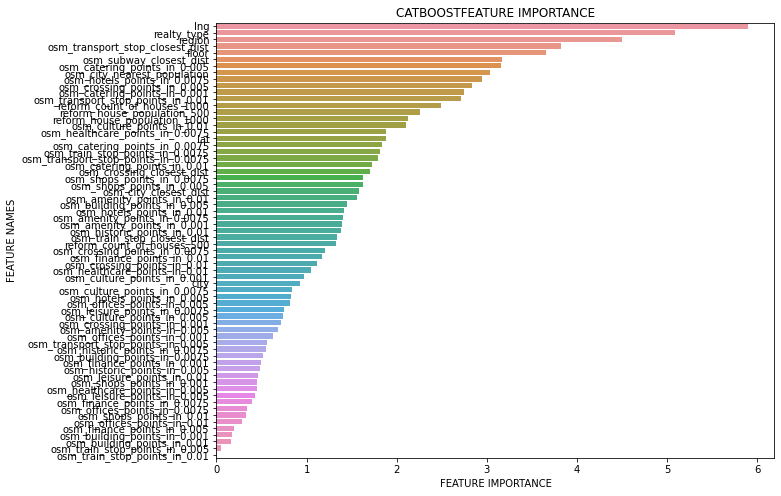

In [636]:
plot_feature_importance(pipeline.get_feature_importance(),X_offer.columns,'CATBOOST')

In [637]:
corr_coef = find_corr_coefficient(pipeline, X_offer, y_offer)

In [638]:
predictions_offer =pipeline.predict(X_offer)
metrics = metrics_stat(y_offer.values, predictions_offer)
print(metrics)

{'mape': 1.8276081777790205, 'mdape': 0.45700155920608826, 'rmse': 147267.48558062315, 'r2': 0.2752888889853069, 'raif_metric': 4.8097409178162085}


In [639]:
predictions_manual = pipeline.predict(X_manual)
metrics = metrics_stat(y_manual.values, predictions_manual/(1+corr_coef))
print(metrics)

{'mape': 0.16709086338123083, 'mdape': 0.14241423413206258, 'rmse': 26094.123841565543, 'r2': 0.914820120376786, 'raif_metric': 0.27146809169876196}


In [640]:

predictions = pipeline.predict(X_sub)
test_df['per_square_meter_price'] = predictions/(1 + corr_coef)

In [641]:
test_df[['id','per_square_meter_price']].to_csv('sub.csv', index=False)

In [ ]:
4.660306639059024
0.06161261163052644}